# Run predictions shifting distribution

Procedure
1. Clone 
```
!git clone https://github.com/dsikar/sdsandbox
```
2. Move source code
```
!mv  sdsandbox/src/* .
```
3. Move image files
```
!mv examples/logs_Wed_Nov_25_23_39_22_2020.tar.gz .
!tar xvf logs_Wed_Nov_25_23_39_22_2020.tar.gz
```

4. Delete bad image
```
!rm logs_Wed_Nov_25_23_39_22_2020/0_cam-image_array_.jpg
```

In [2]:
!git clone https://github.com/dsikar/sdsandbox
!mv  sdsandbox/src/* .
!ls examples
!mv examples/logs_Wed_Nov_25_23_39_22_2020.tar.gz .
!tar xvf logs_Wed_Nov_25_23_39_22_2020.tar.gz
!rm logs_Wed_Nov_25_23_39_22_2020/0_cam-image_array_.jpg

Cloning into 'sdsandbox'...
remote: Enumerating objects: 7381, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 7381 (delta 82), reused 72 (delta 31), pack-reused 7246
Receiving objects: 100% (7381/7381), 721.24 MiB | 25.64 MiB/s, done.
Resolving deltas: 100% (4670/4670), done.
Checking out files: 100% (2262/2262), done.
104_cam-image_array_.jpg   logs_Wed_Nov_25_23_39_22_2020.tar.gz
20201207192948_nvidia2.h5
logs_Wed_Nov_25_23_39_22_2020/0_cam-image_array_.jpg
logs_Wed_Nov_25_23_39_22_2020/1000_cam-image_array_.jpg
logs_Wed_Nov_25_23_39_22_2020/1001_cam-image_array_.jpg
logs_Wed_Nov_25_23_39_22_2020/1002_cam-image_array_.jpg
logs_Wed_Nov_25_23_39_22_2020/1003_cam-image_array_.jpg
logs_Wed_Nov_25_23_39_22_2020/1004_cam-image_array_.jpg
logs_Wed_Nov_25_23_39_22_2020/1005_cam-image_array_.jpg
logs_Wed_Nov_25_23_39_22_2020/1006_cam-image_array_.jpg
logs_Wed_Nov_25_23_39_22_2020/1007_cam-image_array_.jpg
logs_Wed_Nov_25_

In [7]:
def GetJSONSteeringAngles(filemask):
    """
    Get steering angles stored as 'user/angle' attributes in .json files
    Inputs:
        filemask: string, path and mask
    Outputs
        svals: list, steering values
    """
    filemask = os.path.expanduser(filemask)
    path, mask = os.path.split(filemask)

    matches = []
    for root, dirnames, filenames in os.walk(path):
        for filename in fnmatch.filter(filenames, mask):
            matches.append(os.path.join(root, filename))
    # sort by create date
    # matches = sorted(matches, key=os.path.getmtime)
    # sort by filename prefix
    matches = sort_sdsandbox_files(matches)
    # steering values
    svals = []
    for fullpath in matches:
      # print(fullpath)
      frame_number = os.path.basename(fullpath).split("_")[0]
      json_filename = os.path.join(os.path.dirname(fullpath), "record_" + frame_number + ".json")
      jobj = load_json(json_filename)
      svals.append(jobj['user/angle'])
    return svals

def load_json(filepath):
    """
    Load a json file
    Inputs
        filepath: string, path to file
    Outputs
        data: dictionary, json key, value pairs
    Example
    path = "~/git/msc-data/unity/roboRacingLeague/log/logs_Sat_Nov_14_12_36_16_2020/record_11640.json"
    js = load_json(path)
    """
    with open(filepath, "rt") as fp:
        data = json.load(fp)
    return data 

def sort_sdsandbox_files(matches):
  """
  Sort sdsandbox files in format e.g. 'logs_Wed_Nov_25_23_39_22_2020/1339_cam-image_array_.jpg'
  This is to emulate a sort-by-date feature, once files have been copied and datetime stamp is lost

  Parameters
  -------
  matches: list of strings, image filepaths

  Output
  -------
  sorted_matches: list of strings, sorted list

  Example
  -------
  matches = sort_sdsandbox_files(matches)
  for match in matches:
    print(match)
  """
  filenums = {}
  sorted_matches = []
  for match in matches:
    # match ~ 'logs_Wed_Nov_25_23_39_22_2020/1339_cam-image_array_.jpg'
    # match.split('/')[-1].split('_')[0] ~ 1339
    filenums[int(match.split('/')[-1].split('_')[0])] = match

  filenums = sorted(filenums.items(), key=lambda filenums: filenums[0])
  for key in filenums:
    sorted_matches.append(key[1]) 

  return sorted_matches        

def GetPredictions(filemask, modelpath, datashift = 0, modelname = 'nvidia2'):
    """
    Get predictions of a given model
    
    Parameters
    -------
        filemask: string, path of the images to generate steering angle predictions
        modelpath: string, path of the trained model 
        datashift: integer, RGB intensity mean shift to left (negative) or right (positive) or 
        input image RGB intensity mean
        modelname: string, model name refering to input geometry to use
    
    Output
    -------
        predictions: numpy array of floats, steering angle predictons
        
    Example:
    filemask = '../../../../Downloads/dataset/unity/genTrack/genTrackOneLap/logs_Wed_Nov_25_23_39_22_2020/*.jpg'
    modelpath = '../../../../Downloads/trained_models/nvidia2/20201207192948_nvidia2.h5'
    datashift = -10
    filename = 'nvidia2'
    
    p = GetPredictions(filemask, modelpath, datashift)
    
    """
    import os
    from tensorflow.python.keras.models import load_model
    import cv2
    import Augment_cls    
    import fnmatch
    from PIL import Image
    import numpy as np

    ag = Augment_cls.Augment_cls(modelname)

    model = load_model(modelpath)
    model.compile("sgd", "mse")
    
    filemask = os.path.expanduser(filemask)
    path, mask = os.path.split(filemask)

    matches = []
    for root, dirnames, filenames in os.walk(path):
        for filename in fnmatch.filter(filenames, mask):
            matches.append(os.path.join(root, filename))
    # sort by create date
    matches = sorted(matches, key=os.path.getmtime)
    # sort by filename prefix
    matches = sort_sdsandbox_files(matches)

    # steering values
    svals = []
    for fullpath in matches: 
      #image = cv2.imread(fullpath)
      image = Image.open(fullpath)
      #PIL Image as a numpy array
      image = np.array(image, dtype=np.float32)
      # shift distribution
      image, rgbmean, rgbstd, rgbvar = shiftRGBValues(image, datashift, datashift, datashift)   
      # keep data type for prediction model
      image = np.array(image, dtype=np.float32)   
      #image = ag.resize_expected(image)
      image = ag.preprocess(image)
      image = image.reshape((1,) + image.shape)

      mod_pred = model.predict(image)   
      svals.append(mod_pred)
    preds = []
    # only return steering angles
    for i in range(0, len(svals)):
      preds.append(svals[i][0][0])      
    return preds  

# change rgb values
# https://stackoverflow.com/questions/59320564/how-to-access-and-change-color-channels-using-pil
def shiftRGBValues(img, rv=0, gv=0, bv=0):
  """
  Shift RGB values using PIL, and return mean and standard deviations

  Parameters
  -------
    img: uint8 numpy image array
    rv: integer, value to be added to red channel
    gv: integer, value to be added to green channel
    bv, integer, value to be added to blue channel

  Output
  -------
    myimg: uint8 numpy image array
    rgbmean: float, rgb mean
    rgbstd: float, rgb standard deviation
    rgbvar: float, rgb variance

  Example
  -------
  import matplotlib.pyplot as plt
  import matplotlib.image as mpimg
  img = mpimg.imread('steph.jpeg')
  myimg, rgbmean, rgbstd, rgbvar = changeRGB(img, 60, 0, 0)
  plt.imshow(myimg)
  """
  from PIL import Image
  import numpy as np

  im = Image.fromarray(np.uint8(img))

  # Split into 3 channels
  r, g, b = im.split()

  # Red
  r = r.point(lambda i: i + rv)

  # Green
  g = g.point(lambda i: i + gv)

  # Blue
  b = b.point(lambda i: i + bv)

  # Recombine back to RGB image
  result = Image.merge('RGB', (r, g, b))

  rgbmean = np.mean(result) 
  rgbstd = np.std(result) 
  rgbvar = np.var(result) 
  # Convert to uint8 numpy array
  myimg = np.asarray(result)

  return myimg, rgbmean, rgbstd, rgbvar    

def gos(p, g, n):
    """
    Calculate the goodness-of-steer between a prediction and a ground truth array.
    Inputs
        p: array of floats, steering angle prediction
        g: array of floats, steering angle ground truth.
        n: float, normalization constant
    Output
        gos: float, average of absolute difference between ground truth and prediction arrays
    """
    # todo add type assertion
    assert len(p) == len(g), "Arrays must be of equal length"
    return sum(abs(p - g)) / len(p) * n
    # print("Goodness of steer: {:.2f}".format(steer))

# Load and compile trained Tensorflow model

In [7]:
from tensorflow.python.keras.models import load_model
# import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import Augment_cls
modelpath = 'examples/20201207192948_nvidia2.h5'
modelname = 'nvidia2'
ag = Augment_cls.Augment_cls(modelname)
print("loading model", modelpath)
model = load_model(modelpath)
model.compile("sgd", "mse")

loading model examples/20201207192948_nvidia2.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/core.py:1055: UserWarning: models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.0008814618922770023


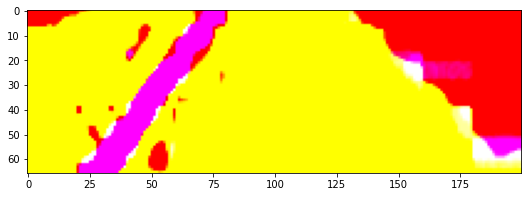

In [38]:
from PIL import Image
import numpy as np
fullpath = 'logs_Wed_Nov_25_23_39_22_2020/10_cam-image_array_.jpg'
# image = mpimg.imread(fullpath) # cv2.imread(fullpath) # cv2 inverts R and B channels # 6.671416759490967
image = Image.open(fullpath)
#PIL Image as a numpy array

image = np.array(image, dtype=np.float32)
# image = cv2.imread(fullpath) # 6.4248524606227875 - does not seem to make much of a difference
# The image will be 1. resized to expected pre-processing size and 2.resized to expected
# size to be presented to network. This is network architecture and dataset dependant and
# currently managed in conf.py

# set to same image size expected from acquisition process
image = ag.resize_expected(image)
image = ag.preprocess(image)
#image = np.array(image, dtype=np.uint8)
plt.imshow(image)
image = np.array(image, dtype=np.float32)
image = image.reshape((1,) + image.shape)
mod_pred = model.predict(image)
print(mod_pred[0][0] * 25)

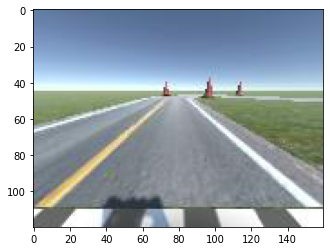

In [10]:
from PIL import Image
from io import BytesIO
import base64
# image = Image.open(BytesIO(base64.b64decode(fullpath))) # Incorrect padding
image = Image.open(fullpath)
plt.imshow(image)

In [10]:
import tensorflow
print(tensorflow.__version__) # 2.8.0
# we need 2.2.0

2.8.0


In [ ]:
# %tensorflow_version 2.2.0
!pip install tensorflow==2.2.0
import tensorflow
print(tensorflow.__version__) # 2.2.0

2.2.0


In [9]:
# runtime 1 minute, 1.4k predictions
filemask = 'logs_Wed_Nov_25_23_39_22_2020/*.jpg'
modelpath = 'examples/20201207192948_nvidia2.h5'
modelname = 'nvidia2'
datashift = 0
p = GetPredictions(filemask, modelpath, datashift, modelname)
# pPlus110 = GetPredictions(filemask, modelpath, datashift, modelname)
# Error with path: logs_Wed_Nov_25_23_39_22_2020/0_cam-image_array_.jpg

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/core.py:1055: UserWarning: models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


In [ ]:
for i in range (-100, -1):
  print(i)

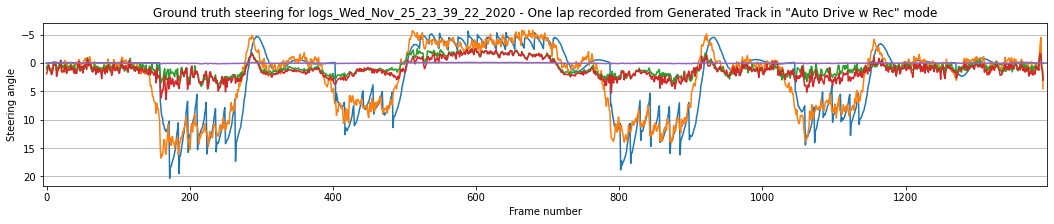

In [75]:
import os
import fnmatch
import json
import numpy as np
import matplotlib.pyplot as plt
# plot ground truth steering angles for
filemask = 'logs_Wed_Nov_25_23_39_22_2020/*.jpg'
g = GetJSONSteeringAngles(filemask)
# g = preds # 'str' object is not callable
# get predictions:
p = np.asarray(p)
#  = GetPredictions(filemask, datashift)
# print(type(g)) # list
g = np.asarray(g)
#pMinus0 = np.asarray(pMinus0)
pMinus1 = np.asarray(pMinus1)
pMinus5 = np.asarray(pMinus5)
#pMinus10 = np.asarray(pMinus10)
#pMinus20 = np.asarray(pMinus20)
#pMinus30 = np.asarray(pMinus30)
pMinus50 = np.asarray(pMinus50)
pMinus60 = np.asarray(pMinus60)
pplus60 = np.asarray(pplus60)
pPlus100 = np.asarray(pPlus100)
pPlus110 = np.asarray(pPlus110)
pPlus100 = np.asarray(pPlus120)


# print(type(g)) # <class 'numpy.ndarray'>
plt.rcParams["figure.figsize"] = (18,3)
nc = 25 # norm. constant, maximum steering angle

plt.plot(g*nc)
plt.plot(p*nc)
#plt.plot(pMinus0*nc)
#plt.plot(pMinus1*nc)
#plt.plot(pMinus5*nc)
#plt.plot(pMinus10*nc)
#plt.plot(pMinus20*nc)
#plt.plot(pMinus30*nc)
#plt.plot(pMinus50*nc)
#plt.plot(pMinus60*nc)
#plt.plot(pplus60*nc)
plt.plot(pPlus100*nc)
plt.plot(pPlus110*nc)
plt.plot(pPlus120*nc)
# plt.plot(sarr[:,1]*25, label="simulator")

plt.ylabel('Steering angle')
plt.xlabel('Frame number')    
# Set a title of the current axes.
mytitle = 'Ground truth steering for logs_Wed_Nov_25_23_39_22_2020 - One lap recorded from Generated Track in "Auto Drive w Rec" mode'
plt.title(mytitle)
plt.grid(axis='y')
# set limit
plt.xlim([-5,len(g)+5])
plt.gca().invert_yaxis()
plt.show()

In [71]:
print(gos(p,g,25))
print(gos(pMinus1,g,25))
print(gos(pMinus5,g,25))
#print(gos(pMinus10,g,25))
#print(gos(pMinus20,g,25))
print(gos(pMinus50,g,25))
print(gos(pMinus60,g,25))
print(gos(pplus60,g,25))
print(gos(pPlus100,g,25))
print(gos(pPlus110,g,25))
print(gos(pPlus120,g,25))

1.6829038607492623
1.6828615072840343
1.6829082494475864
1.7014767893975953
1.706200431131276
2.2658771934493545
3.2542654030617726
3.6825313317011763


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


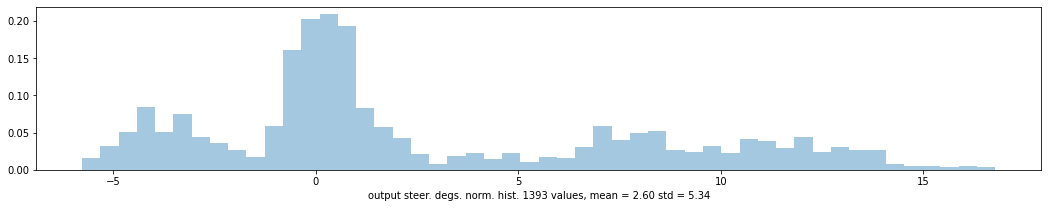

In [ ]:
def listSteeringBins(svals, pname="output", save=True, nc=25, rmout=0):
    """
    Plot a steering values' histogram
    Inputs
        svals: list, array of normalized steering values
        pname: string, output plot name
        save: boolean, save plot to disk
        nc: int, normalization constant, used in the simulator to put angles in range
        -1, 1. Default is 25.
        rmout: integer, outlier range to remove
    Outputs
        none
    """
    svalscp = [element * nc for element in svals]
    values = len(svals)
    
    # remove outliers
    if(rmout>0):
        #my_iterator = filter(lambda svalscp: svalscp <= rmout and svalscp >= (-1 * rmout), svalscp)
        #svalsrmout = list(my_iterator)
        #svalscp = svalsrmout
        #values = len(svalsrmout)
        #print("Removed {} records".format(len(svals) - len(svalsrmout)))
        #svals = svalsrmout
        svals = removeOutliers(svalscp, rmout, nc)
        values = len(svals)
    mean = ("%.2f" % statistics.mean(svalscp))
    std = ("%.2f" % statistics.stdev(svalscp))
    plt.title=(pname)
    # NB Plotted as normalized histogram
    sns.distplot(svalscp, bins=nc*2, kde=False, norm_hist=True, 
    axlabel= pname + ' steer. degs. norm. hist. ' + str(values) + ' values, mean = ' + mean + ' std = ' + std)
    #if(save):
    #    sns.save("output.png")
    if(save):
        plt.savefig(pname + '.png')
    plt.show()

listSteeringBins(preds)

In [ ]:
g.shape # (1394,)
p[0] # array([[0.10689256, 0.26171982]], dtype=float32)
p[0][0] # array([0.10689256, 0.26171982], dtype=float32)
p[0][0][0] # 0.106892556
p[0][0][1] # 0.26171982 
p[1] # array([[0.10308309, 0.262734  ]], dtype=float32)
p[1][0] # array([0.10308309, 0.262734  ], dtype=float32)
# p[1][1] # index 1 is out of bounds for axis 0 with size 1
p[1][0][0] # 0.10308309 # assumed steering angle
p[1][0][1] # 0.262734 # assumed acceleration
len(p) # 1393
preds = []
for i in range(0, len(p)):
  preds.append(p[i][0][0])


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


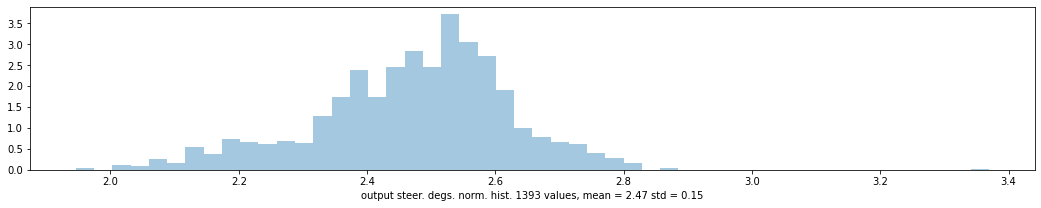

In [ ]:
listSteeringBins(preds)

# Positive steering angle example, labelled dataset

In [ ]:
# 1105_cam-image_array_.jpg
#!ls logs_Wed_Nov_25_23_39_22_2020/1105_cam-image_array_.jpg
# !ls logs_Wed_Nov_25_23_39_22_2020/*1105*
!cat logs_Wed_Nov_25_23_39_22_2020/record_1105.json
# {"cam/image_array":"1105_cam-image_array_.jpg","user/throttle":0.0,"user/angle":0.31525176763534548,"user/mode":"user","track/lap":0,"track/loc":21}
# 0.31525176763534548 * 25 = 7.88129419088 ~ 7.9 degrees

{"cam/image_array":"1105_cam-image_array_.jpg","user/throttle":0.0,"user/angle":0.31525176763534548,"user/mode":"user","track/lap":0,"track/loc":21}

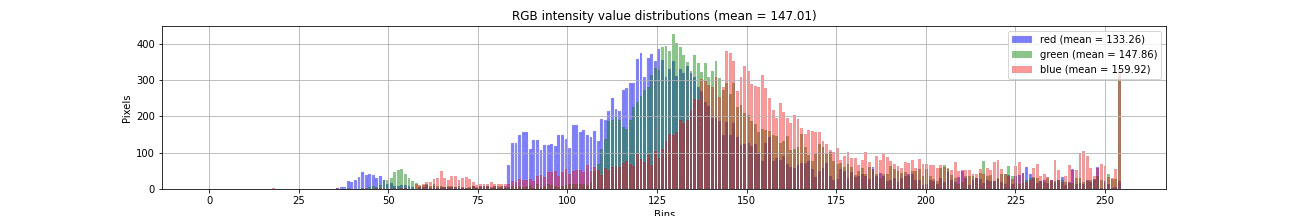

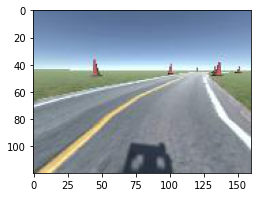

In [67]:
from utils.utils import plot_img_hist # need utils.py
from PIL import Image
from google.colab.patches import cv2_imshow
imgpath = 'logs_Wed_Nov_25_23_39_22_2020/1105_cam-image_array_.jpg'
image = Image.open(imgpath)
plt.imshow(image)
myfig = plot_img_hist(image)
myplot = mpimg.imread('temp_plot.jpg')
cv2_imshow(myplot)

# Shift and plot

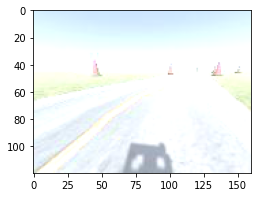

In [69]:
# image = Image.open(imgpath)
datashift = 120
imageshifted, rgbmean, rgbstd, rgbvar = shiftRGBValues(image, datashift, datashift, datashift)
plt.imshow(imageshifted)

In [66]:
type(image) # PIL.JpegImagePlugin.JpegImageFile


PIL.JpegImagePlugin.JpegImageFile